In [1]:
import functools
import glob
import os

In [2]:
import coord
import fitsio
import galsim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import BallTree
from sklearn.metrics.pairwise import haversine_distances

In [3]:
# TODO: use NN in RA/Dec
# scale with ratio of Ts (scale by T_pred / T_true)

In [4]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"
os.environ["PATH"] += ":/global/common/software/nersc/pm-2023q2/sw/texlive/2022/bin/x86_64-linux"

In [5]:
des_cosmos_catalog = "/global/cfs/cdirs/desbalro/des_cosmos_data_v2.fits"

In [6]:
# source_catalog = "/global/cfs/cdirs/desbalro/input_cosmos_v4.fits"

In [7]:
truth_catalog = "/global/cfs/cdirs/desbalro/input_cosmos_v4_montara_simcat_v7_seed42.fits"

In [8]:
deepfield_catalog = "/global/cfs/cdirs/desbalro/DES_DF_COSMOS.fits"

In [9]:
source_table = fitsio.read(des_cosmos_catalog)
source_id = source_table["id_des"]

In [10]:
# source_table = fitsio.read(source_catalog)
# source_id = source_table["des_id"]

In [11]:
truth_table = fitsio.read(truth_catalog)
truth_id = truth_table["des_id"]

In [12]:
deepfield_table = fitsio.read(deepfield_catalog)
deepfield_id = deepfield_table["ID_DES"]

In [13]:
_, source_truth_indices, truth_source_indices = np.intersect1d(
    source_id,
    truth_id,
    return_indices=True,
)

In [14]:
_, truth_deepfield_indices, deepfield_truth_indices = np.intersect1d(
    truth_id,
    deepfield_id,
    return_indices=True,
)

In [15]:
np.testing.assert_allclose(
    source_table[source_truth_indices]["ra"],
    deepfield_table[deepfield_truth_indices]["RA"],
)

In [16]:
np.testing.assert_allclose(
    source_table[source_truth_indices]["dec"],
    deepfield_table[deepfield_truth_indices]["DEC"],
)

In [17]:
# assert magnitudes are equal
for band in ["g", "r", "i", "z"]:
    np.testing.assert_allclose(
        truth_table[truth_deepfield_indices][f"mag_{band}"],
        deepfield_table[deepfield_truth_indices][f"MAG_{band}"],
    )

In [18]:
# assert magnitudes transform to fluxes ok
for band in ["g", "r", "i", "z"]:
    _df_flux = np.power(
        10,
        -0.4 * (deepfield_table[deepfield_truth_indices][f"MAG_{band}"] - 30),
    )
    np.testing.assert_allclose(
        truth_table[truth_deepfield_indices][f"flux_{band}"],
        _df_flux,
    )


In [19]:
df_flux = np.power(
    10,
    -0.4 * (deepfield_table[deepfield_truth_indices]["MAG_r"] - 30),
)
df_flux_err = np.power(
    10,
    -0.4 * (deepfield_table[deepfield_truth_indices]["ERR_MAG_r"] - 30),
)

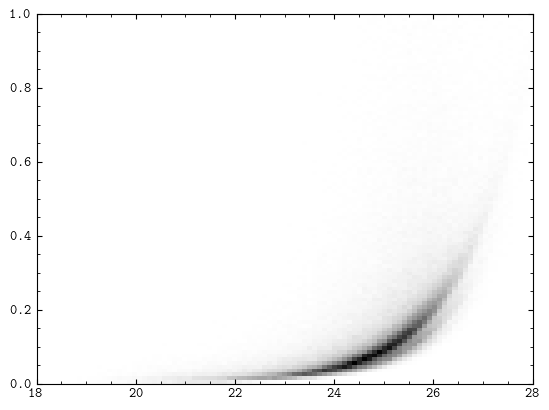

In [20]:
plt.hist2d(
    deepfield_table[deepfield_truth_indices]["MAG_r"],
    deepfield_table[deepfield_truth_indices]["ERR_MAG_r"],
    bins=[np.linspace(18, 28, 100), np.linspace(0, 1, 100)],
)
plt.show()

$$ f = 10^{-(m - 30) / 2.5} $$

$$ \sigma_f^2 = \left(\frac{\partial f}{\partial m}\right)^2 \sigma_m^2 $$

$$ \frac{\partial f}{\partial m} = -\frac{1}{2.5} \ln 10 \times 10^{-(m - 30) / 2.5} $$


$$ \sigma_f^2 = \left(-\frac{1}{2.5} \ln 10 \times 10^{-(m - 30) / 2.5}\right)^2 \sigma_m^2 $$
$$ \sigma_f = \frac{\ln 10}{2.5} \times 10^{-(m - 30) / 2.5} \sigma_m $$

In [21]:
df_flux = np.power(
    10,
    -0.4 * (deepfield_table[deepfield_truth_indices]["MAG_r"] - 30),
)

In [22]:
df_flux_err = np.log(10) / 2.5 * np.power(
    10,
    -0.4 * (deepfield_table[deepfield_truth_indices]["MAG_r"] - 30),
) * deepfield_table[deepfield_truth_indices]["ERR_MAG_r"]

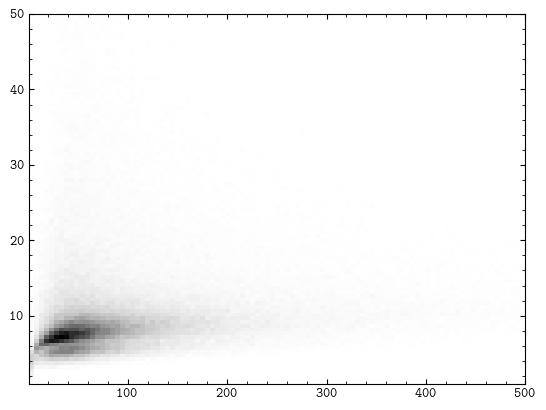

In [23]:
plt.hist2d(
    df_flux,
    df_flux_err,
    bins=[np.linspace(1, 500, 100), np.linspace(1, 50, 100)],
)
plt.show()

In [24]:
DEEPFIELD_BANDS = ["u", "g", "r", "i", "z", "Y", "J", "H", "K"]

---

# Train KNN on fluxes

In [25]:
# assert magnitudes transform to fluxes ok
table = {}
for band in DEEPFIELD_BANDS:
    
    _mag = deepfield_table[deepfield_truth_indices][f"MAG_{band}"]
    _mag_err = deepfield_table[deepfield_truth_indices][f"ERR_MAG_{band}"]
    
    _flux = np.power(
        10,
        -(_mag - 30) / 2.5,
    )
    _flux_err = np.log(10) / 2.5 * _flux * _mag_err
    
    table[f"flux_{band}"] = _flux
    table[f"flux_err_{band}"] = _flux_err

In [26]:
_X = np.array(
    [
        table[f"flux_{band}"]
        for band in DEEPFIELD_BANDS
    ]
).T

_y = np.array(
    [
        table[f"flux_err_{band}"]
        for band in DEEPFIELD_BANDS
    ]
).T

In [27]:
# knn with distance weighting
knn = KNeighborsRegressor(weights="distance")

In [28]:
n_train = len(_X)  * 3 // 4

In [29]:
knn.fit(
    _X[:n_train],
    _y[:n_train],
)

KNeighborsRegressor(weights='distance')

In [30]:
y_pred = knn.predict(_X[n_train:])
y_true = _y[n_train:]

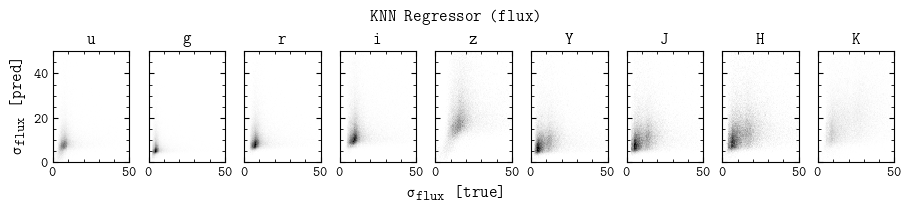

In [31]:
fig, axs = plt.subplots(1, len(DEEPFIELD_BANDS), sharex=True, sharey=True, constrained_layout=True, figsize=(9, 2))

for i, band in enumerate(DEEPFIELD_BANDS):
    axs[i].hist2d(
        y_true[:, i],
        y_pred[:, i],
        bins=[np.linspace(0, 50, 101), np.linspace(0, 50, 101)],
        # norm="log",
    )

    axs[i].set_title(band)

fig.supylabel("$\\sigma_{flux}$ [pred]")
fig.supxlabel("$\\sigma_{flux}$ [true]")
fig.suptitle("KNN Regressor (flux)")

plt.show()

# Train KNN on sky position

In [32]:
# assert magnitudes transform to fluxes ok
table = {}

table["ra"] = deepfield_table[deepfield_truth_indices]["RA"]
table["dec"] = deepfield_table[deepfield_truth_indices]["DEC"]
table["hlr"] = deepfield_table[deepfield_truth_indices]["COSMOS_HLR"]

for band in DEEPFIELD_BANDS:
    
    _mag = deepfield_table[deepfield_truth_indices][f"MAG_{band}"]
    _mag_err = deepfield_table[deepfield_truth_indices][f"ERR_MAG_{band}"]
    
    _flux = np.power(
        10,
        -(_mag - 30) / 2.5,
    )
    _flux_err = np.log(10) / 2.5 * _flux * _mag_err
    
    table[f"flux_{band}"] = _flux
    table[f"flux_err_{band}"] = _flux_err

In [33]:
_X = np.array(
    [
        np.deg2rad(table["ra"]),
        np.deg2rad(table["dec"]),
    ]
).T

_y = np.array(
    [
        table[f"flux_err_{band}"]
        for band in DEEPFIELD_BANDS
    ]
).T

In [34]:
n_train = len(_X)  * 3 // 4

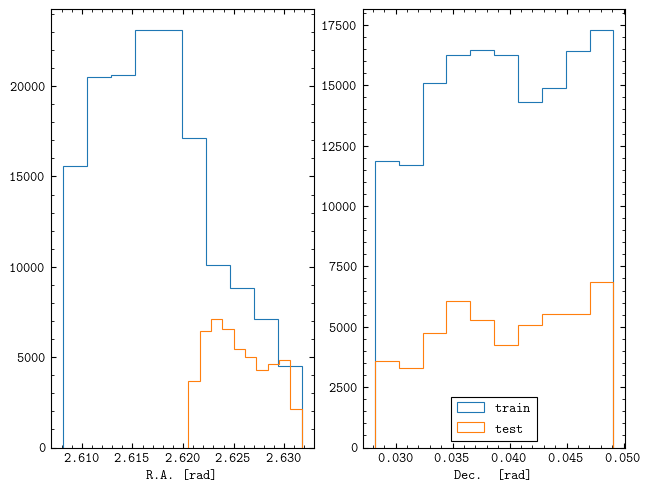

In [35]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)

axs[0].hist(
    _X[:n_train, 0],
    histtype="step",
    label="train",
)
axs[0].hist(
    _X[n_train:, 0],
    histtype="step",
    label="test",
)
axs[0].set_xlabel("R.A. [rad]")

axs[1].hist(
    _X[:n_train, 1],
    histtype="step",
    label="train",
)
axs[1].hist(
    _X[n_train:, 1],
    histtype="step",
    label="test",
)
axs[1].set_xlabel("Dec. [rad]")

axs[1].legend()

plt.show()

In [36]:
bt = BallTree(
    _X[:n_train],
    metric="haversine",
)

In [37]:
y_true = _y[n_train:]

## First, make an attempt for a slice of one object

In [38]:
neighbor_distances, neighbor_indices = bt.query(_X[n_train:n_train + 1], k=5, return_distance=True)

In [39]:
# average weighted by distance
np.average(_y[:n_train][neighbor_indices], weights=neighbor_distances.ravel(), axis=1)

array([[ 45.31438138,  32.38817571,  54.68685459,  63.20338693,
        123.18329899,  22.37065383,  27.80759565,  34.09170944,
         49.01014214]])

In [40]:
# rescale according to size ratio
_y[:n_train][neighbor_indices] * (table["hlr"][n_train:n_train + 1] / table["hlr"][:n_train][neighbor_indices])[:,:,np.newaxis]

array([[[22.92694154, 16.71805156, 26.52504958, 29.83840761,
         54.66571031, 12.0562349 , 14.94063398, 18.11391165,
         25.78961779],
        [14.26600138, 10.50253545, 17.53611   , 20.19832318,
         40.29735315,  6.69825745,  8.39728771, 10.42653131,
         15.0853023 ],
        [ 5.62848384,  3.76121008,  6.67592934,  7.94419484,
         15.62564763,  2.65893738,  3.26465507,  3.96742505,
          5.70805792],
        [ 6.30442527,  4.52195291,  7.05655871,  8.37402871,
         16.76938005,  3.13154413,  3.79632598,  4.55312025,
          6.52409019],
        [ 3.86807201,  2.34006787,  5.1198097 ,  6.21403494,
         12.44416601,  2.051828  ,  2.54051169,  3.1046726 ,
          4.47151886]]])

In [41]:
# rescale according to size ratio and take the distance-weighted average
np.average(
    _y[:n_train][neighbor_indices] * (table["hlr"][n_train:n_train + 1] / table["hlr"][:n_train][neighbor_indices])[:,:,np.newaxis],
    weights=neighbor_distances.ravel(),
    axis=1,
)

array([[ 9.33366945,  6.61277377, 11.10527681, 12.87312554, 24.93133067,
         4.6767691 ,  5.78496037,  7.05008159, 10.11117866]])

In [42]:
# reference value
_y[n_train:n_train + 1]

array([[ 8.95073846,  6.38086986,  9.68096036, 11.13831472, 19.69804725,
         4.42508848,  5.34907691,  6.35156799,  8.94780757]])

## next, try for entire sample

In [43]:
neighbor_distances, neighbor_indices = bt.query(_X[n_train:], k=5, return_distance=True)

In [44]:
_y[:n_train][neighbor_indices].shape, neighbor_distances.shape

((50192, 5, 9), (50192, 5))

In [45]:
# weighted average with broadcasting
np.sum(_y[:n_train][neighbor_indices] * neighbor_distances[:, :, np.newaxis], axis=1) / np.sum(neighbor_distances, axis=1)[:, np.newaxis]

array([[45.31438138, 32.38817571, 54.68685459, ..., 27.80759565,
        34.09170944, 49.01014214],
       [10.48207777,  6.7328322 ,  9.94065399, ...,  6.55603608,
         7.90400243, 11.32427325],
       [20.82568458, 14.67567522, 26.1785285 , ..., 21.97646478,
        27.45579449, 40.27626742],
       ...,
       [ 9.20075425,  6.77904271, 10.91809272, ..., 25.87981555,
        32.41905109, 49.86019558],
       [15.63382604, 10.57313521, 16.99821066, ..., 37.97256243,
        48.44683617, 74.49350679],
       [13.12733909, 10.20011782, 17.10538783, ..., 41.90776966,
        53.8711293 , 83.49138815]])

In [46]:
table["hlr"][n_train:].shape, table["hlr"][:n_train][neighbor_indices].shape

((50192,), (50192, 5))

In [47]:
table["hlr"][n_train:][:, np.newaxis] / table["hlr"][:n_train][neighbor_indices]

array([[0.25746792, 0.10869659, 0.30573047, 0.55635542, 0.22336563],
       [0.94652812, 2.68839143, 1.48322887, 0.58772522, 0.88750208],
       [1.19662635, 0.61308713, 0.42740502, 0.64450904, 2.15623725],
       ...,
       [1.94287622, 1.72715358, 1.25968352, 1.95086164, 2.47050677],
       [1.19218547, 0.1935673 , 0.29871452, 0.39719486, 0.64979615],
       [0.49137131, 0.43681307, 0.31858558, 0.4933909 , 0.28028523]])

In [48]:
y_pred = np.mean(
    _y[:n_train][neighbor_indices] \
    * (table["hlr"][n_train:][:, np.newaxis] / table["hlr"][:n_train][neighbor_indices])[:, :, np.newaxis],
    axis=1,
)

In [49]:
# rescale according to size ratio and take the distance-weighted average
y_pred = np.sum(
    _y[:n_train][neighbor_indices] \
    * (table["hlr"][n_train:][:, np.newaxis] / table["hlr"][:n_train][neighbor_indices])[:, :, np.newaxis] \
    *  neighbor_distances[:, :, np.newaxis],
    axis=1,
) / np.sum(neighbor_distances, axis=1)[:, np.newaxis]

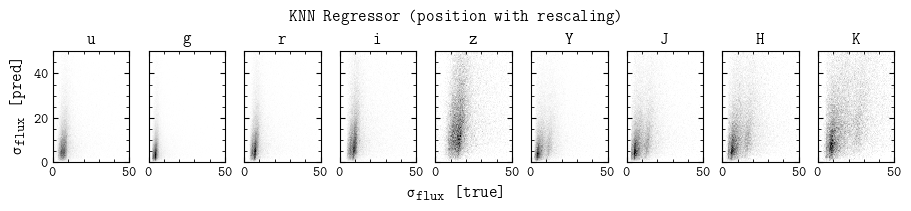

In [50]:
fig, axs = plt.subplots(1, len(DEEPFIELD_BANDS), sharex=True, sharey=True, constrained_layout=True, figsize=(9, 2))

for i, band in enumerate(DEEPFIELD_BANDS):
    axs[i].hist2d(
        y_true[:, i],
        y_pred[:, i],
        bins=[np.linspace(0, 50, 101), np.linspace(0, 50, 101)],
        # norm="log",
    )

    axs[i].set_title(band)

fig.supylabel("$\\sigma_{flux}$ [pred]")
fig.supxlabel("$\\sigma_{flux}$ [true]")
fig.suptitle("KNN Regressor (position with rescaling)")

plt.show()